# CAPTCHA Letter Extraction and Classification

This notebook demonstrates the process of extracting letters from CAPTCHA images and classifying them using a deep learning model. The steps involved are:

1. **Importing Libraries**: Importing necessary libraries for image processing, machine learning, and deep learning.
2. **Helper Functions**: Defining helper functions for image display and letter extraction.
3. **Data Preparation**: Loading CAPTCHA images, extracting letters, and preparing the dataset.
4. **Data Augmentation**: Applying data augmentation techniques to increase the size and variability of the dataset.
5. **Model Creation**: Creating and compiling a Convolutional Neural Network (CNN) model for letter classification.
6. **Model Training**: Training the model with the prepared dataset and applying class weights to handle class imbalance.
7. **Evaluation and Visualization**: Evaluating the model's performance and visualizing the results.
8. **Testing on New CAPTCHAs**: Testing the trained model on new CAPTCHA images and displaying the results.

Let's get started!

In [3]:
from IPython.display import clear_output  # fixed import for clear_output
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split  # fixed typo here
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import joblib
from time import sleep
import time


In [4]:
def show_image(image):
    plt.close()
    plt.imshow(image , cmap='gray')
    plt.show()

## Letter Extraction from CAPTCHA Images

In this section, we define a function to extract individual letters from CAPTCHA images using a pre-trained YOLO model. The function processes each image, detects the bounding boxes around the letters, and extracts and resizes each letter for further processing.

### Function: `extract_letters_from_captcha`

- **Parameters**:
    - `image_path` (str): The path to the CAPTCHA image.
    - `model_yolo` (YOLO): The pre-trained YOLO model for letter detection.

- **Returns**:
    - `letters` (list): A list of extracted letter images.
    - `label` (list): The corresponding label for each letter.
    - `error` (list): A list of errors encountered during processing.

The function also includes a helper function `check_letter_tarakom` to verify the quality of the extracted letters.

### Usage

The function is used to process all CAPTCHA images in the dataset, extract the letters, and prepare them for training a deep learning model for letter classification.

In [5]:
def extract_letters_from_captcha(image_path, model_yolo):
    def check_letter_tarakom(pic):
        _, pic = cv2.threshold(pic, 127, 255, cv2.THRESH_BINARY)
        s = 90 - (np.sum(pic , axis=0 , keepdims=True) / 255)
        total = len(s[0])
        howmanyblack = 0
        for i in s[0]:
            if np.sum(i) >= 175:
                howmanyblack += 1
        if total - howmanyblack <= 22:
            return True
        else:
            return False
    letters = []
    detected = []

    how_many = 1

    try:
        image = cv2.imread(image_path)  


        results = model_yolo(image_path)
        detections = results[0].boxes
        detections = sorted(detections, key=lambda box: box.xyxy[0][0]) 
        
        last_one = []

        howmany = 0 
        for box in detections:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            if last_one != []:
                if int(x1) - last_one[0] > 10:
                    letter_crop = image[y1:y2, x1:x2] 
                    resized_letter = cv2.resize(letter_crop, (32, 52)) 
                    resized_letter = cv2.cvtColor(resized_letter, cv2.COLOR_BGR2GRAY) 
                    if howmany == 8:
                        if check_letter_tarakom(letter_crop) == True:
                            _, binarized = cv2.threshold(resized_letter, 128, 255, cv2.THRESH_BINARY)
                            letters.append(resized_letter)
                    elif howmany <= 7:
                        _, binarized = cv2.threshold(resized_letter, 128, 255, cv2.THRESH_BINARY)
                        letters.append(resized_letter)
                    last_one = [int(x1), int(y1), int(x2), int(y2)]
                    howmany += 1
            else:
                letter_crop = image[y1:y2, x1:x2] 
                resized_letter = cv2.resize(letter_crop, (32, 52)) 
                resized_letter = cv2.cvtColor(resized_letter, cv2.COLOR_BGR2GRAY)
                if check_letter_tarakom(letter_crop) == True:
                        _, binarized = cv2.threshold(resized_letter, 128, 255, cv2.THRESH_BINARY)
                        letters.append(resized_letter)
                last_one = [int(x1), int(y1), int(x2), int(y2)]
                howmany += 1
        print(len(letters))
        error = []
        if len(letters) == 5 or len(letters) == 8:
            print("yes")
            label = os.path.basename(image_path.split(sep="/")[1]).split(".")[0]
            return letters, list(label) , error
        else:
            print(how_many , " Ignored")
            how_many += 1
            error.append(label)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return [], []


In [6]:
files = os.listdir("kaggledataset")

In [9]:
images = []
labels = []
for file in files:
    result = extract_letters_from_captcha(f"kaggledataset/{file}" , model_yolo=model_yolo)
    try:
        for i in range(0,len(result[0])):
            images.append(result[0][i])
        for i in result[1]:
            labels.append(i)
    except Exception as e:
        print("-------------")



image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/p5g5m.png: 160x640 7 characterss, 16.2ms
Speed: 0.6ms preprocess, 16.2ms inference, 0.5ms postprocess per image at shape (1, 3, 160, 640)
5
yes

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/e72cd.png: 160x640 5 characterss, 15.3ms
Speed: 0.5ms preprocess, 15.3ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 640)
5
yes

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/pgmn2.png: 160x640 5 characterss, 16.2ms
Speed: 0.4ms preprocess, 16.2ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 640)
5
yes

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/6cm6m.png: 160x640 5 characterss, 16.3ms
Speed: 0.4ms preprocess, 16.3ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 640)
5
yes

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/56dx3mx3.png: 128x640 9 characterss, 19.2ms
Speed: 0.4

In [8]:
# Ensure model_yolo is defined
model_yolo = YOLO("yolo_model2/best.pt")  # Load the YOLO model

# Process files
images = []
labels = []
for file in files:
    result = extract_letters_from_captcha(f"kaggledataset/{file}", model_yolo=model_yolo)
    try:
        for i in range(0, len(result[0])):
            images.append(result[0][i])
        for i in result[1]:
            labels.append(i)
    except Exception as e:
        print("-------------")


image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/p5g5m.png: 160x640 7 characterss, 31.8ms
Speed: 3.4ms preprocess, 31.8ms inference, 7.2ms postprocess per image at shape (1, 3, 160, 640)
5
yes

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/e72cd.png: 160x640 5 characterss, 20.5ms
Speed: 0.4ms preprocess, 20.5ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 640)
5
yes

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/pgmn2.png: 160x640 5 characterss, 19.6ms
Speed: 0.5ms preprocess, 19.6ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 640)
5
yes

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/6cm6m.png: 160x640 5 characterss, 36.6ms
Speed: 0.4ms preprocess, 36.6ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 640)
5
yes

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/56dx3mx3.png: 128x640 9 characterss, 31.0ms
Speed: 0.5

In [10]:
images = []
labels = []
for file in files:
    result = extract_letters_from_captcha(f"kaggledataset/{file}" , model_yolo=model_yolo)
    try:
        for i in range(0,len(result[0])):
            images.append(result[0][i])
        for i in result[1]:
            labels.append(i)
    except Exception as e:
        print("-------------")



image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/p5g5m.png: 160x640 7 characterss, 31.1ms
Speed: 2.1ms preprocess, 31.1ms inference, 0.5ms postprocess per image at shape (1, 3, 160, 640)
5
yes

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/e72cd.png: 160x640 5 characterss, 20.4ms
Speed: 0.7ms preprocess, 20.4ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 640)
5
yes

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/pgmn2.png: 160x640 5 characterss, 19.8ms
Speed: 0.4ms preprocess, 19.8ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 640)
5
yes

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/6cm6m.png: 160x640 5 characterss, 67.6ms
Speed: 0.5ms preprocess, 67.6ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 640)
5
yes

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/56dx3mx3.png: 128x640 9 characterss, 15.6ms
Speed: 0.4

KeyboardInterrupt: 

In [11]:
images = np.array(images)
labels = np.array(labels)
images = images.astype('float32') / 255.0 

In [12]:
img = images[0]

print("Min pixel value:", np.min(img))
print("Max pixel value:", np.max(img))


Min pixel value: 0.0
Max pixel value: 0.85882354


## Data Preparation

In this section, we will prepare the dataset for training our deep learning model. The steps involved are:

1. **Extracting Letters from CAPTCHA Images**: Using the pre-trained YOLO model, we will extract individual letters from the CAPTCHA images.
2. **Storing Extracted Letters and Labels**: We will store the extracted letters and their corresponding labels in separate lists.
3. **Normalizing the Images**: The extracted letter images will be normalized to have pixel values between 0 and 1.

### Steps:

1. **Extract Letters**: Iterate through each CAPTCHA image file, use the `extract_letters_from_captcha` function to extract letters, and store them in the `images` list. The corresponding labels will be stored in the `labels` list.
2. **Normalize Images**: Convert the `images` list to a NumPy array and normalize the pixel values to be between 0 and 1.

By the end of this section, we will have a prepared dataset of letter images and their labels, ready for training our deep learning model.

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

images_uint8 = np.array(images * 255, dtype=np.uint8)


datagen = ImageDataGenerator(
    rotation_range=10,     
    width_shift_range=0.05,      
    height_shift_range=0.05,     
    zoom_range=0.1,             
    shear_range=0.2,          
    brightness_range=[0.5, 1.5], 
    fill_mode='constant',        
    cval=170                 
)

def add_gaussian_noise(image, mean=0, std=8):
    noise = np.random.normal(mean, std, image.shape)  
    noisy_image = image + noise 
    noisy_image = np.clip(noisy_image, 0, 255) 
    return noisy_image.astype(np.uint8)


augmented_images = []
augmented_labels = []

for i, img in enumerate(images_uint8):
    img = np.expand_dims(img, axis=-1) 
    img = np.expand_dims(img, axis=0)

    for _ in range(20):
        aug_img = next(datagen.flow(img, batch_size=1))[0].astype(np.uint8)
        aug_img = aug_img.squeeze()
        aug_img_with_noise = add_gaussian_noise(aug_img)

        augmented_images.append(aug_img_with_noise)
        augmented_labels.append(labels[i])


In [14]:
print(len(augmented_images))
print(len(augmented_labels))

65340
65340


In [15]:
print("images shape : " , images.shape)
print("labels shape : " , labels.shape)

images shape :  (3267, 52, 32)
labels shape :  (3267,)


In [16]:

x = np.concatenate((images, augmented_images), axis=0)
y = np.concatenate((labels, augmented_labels), axis=0)

print(x.shape) 
print(y.shape) 


(68607, 52, 32)
(68607,)


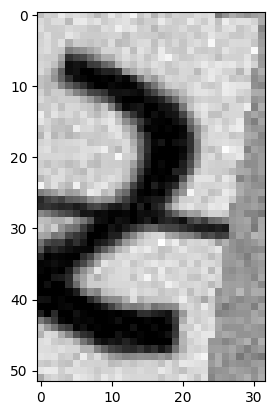

In [19]:
show_image(x[68606])

In [20]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)

one_hot_labels = to_categorical(encoded_labels)

print("Label classes:", label_encoder.classes_)
print("Sample encoded labels:", encoded_labels[:5])
print("Sample one-hot labels:", one_hot_labels[:5])

Label classes: ['2' '3' '4' '5' '6' '7' '8' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'm' 'n' 'p' 'w' 'x' 'y']
Sample encoded labels: [16  3 13  3 14]
Sample one-hot labels: [[          0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           1           0           0           0]
 [          0           0           0           1           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0]
 [          0           0           0           0           0           0           0           0           0           0           0           0           0           1           0           0           0           0           0           0]
 [          0           0           0           1           0           0           0           0           0  

In [22]:
label_encoder.inverse_transform([one_hot_labels[68606].argmax()])

array(['2'], dtype='<U1')

In [ ]:
np.save('x.npy', x)
np.save('one_hot_lables.npy', one_hot_labels)

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

def create_captcha_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.5),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.5),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.5),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_captcha_model((52, 32, 1), one_hot_labels.shape[1])

model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 52, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,492 (1.87 MB)

 Trainable params: 489,044 (1.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels), 
    y=labels
)


early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,     
    restore_best_weights=True 
)

history = model.fit(
    x, one_hot_labels,
    batch_size=14,
    validation_split=0.2,
    epochs=30,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[early_stopping] 
)



Epoch 1/30
3921/3921 ━━━━━━━━━━━━━━━━━━━━ 69s 17ms/step - accuracy: 0.6065 - loss: 1.4693 - val_accuracy: 0.9612 - val_loss: 0.1946
Epoch 2/30
3921/3921 ━━━━━━━━━━━━━━━━━━━━ 3856s 984ms/step - accuracy: 0.8933 - loss: 0.3763 - val_accuracy: 0.9727 - val_loss: 0.1520
Epoch 3/30
 648/3921 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - accuracy: 0.9115 - loss: 0.3198

KeyboardInterrupt: 

In [26]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


NameError: name 'history' is not defined

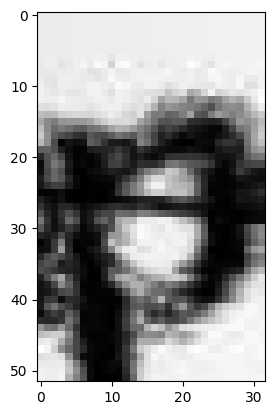

In [27]:
show_image(images[477])

In [28]:
labels[477]

np.str_('p')

In [ ]:
#model.save('FINALMODELS/mymodel.h5')

In [ ]:

# Assuming `label_encoder` is already trained
#joblib.dump(label_encoder, 'trained_label_encoder.pkl')


image number : 400

image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/1.png: 128x640 10 characterss, 37.0ms
Speed: 6.9ms preprocess, 37.0ms inference, 12.9ms postprocess per image at shape (1, 3, 128, 640)


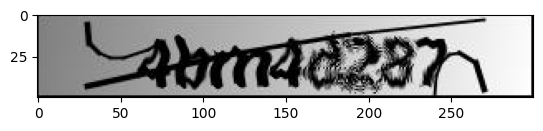

Number of letters extracted: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4bmn4d287


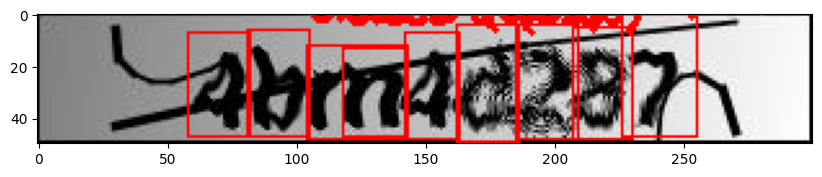

In [32]:
import random
rendnum = random.choice(range(30 , 500))
# image_path_test = f"captchas/captcha_{rendnum}.png"
image_path_test = "kaggledataset/1.png"
print(f"image number : {rendnum}")
image_test = cv2.imread(image_path_test)
model_test = YOLO("yolo_model2/best.pt")
results_test = model_test(image_path_test)
detections_test = results_test[0].boxes
detections_test = sorted(detections_test, key=lambda box: box.xyxy[0][0])

def check_letter_tarakom(pic):
    _, pic = cv2.threshold(pic, 127, 255, cv2.THRESH_BINARY)
    s = 90 - (np.sum(pic , axis=0 , keepdims=True) / 255)
    total = len(s[0])
    howmanyblack = 0
    for i in s[0]:
        if np.sum(i) >= 175:
            howmanyblack += 1
    if total - howmanyblack <= 22:
        return True
    else:
        return False

letters_test = []

last_one = []

howmany = 0 
for box in detections_test:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    if last_one != []:
        if int(x1) - last_one[0] > 10:
            letter_crop = image_test[y1:y2, x1:x2] 
            resized_letter = cv2.resize(letter_crop, (32, 52)) 
            resized_letter = cv2.cvtColor(resized_letter, cv2.COLOR_BGR2GRAY) 
            if howmany == 8:
                if check_letter_tarakom(letter_crop) == True:
                        _, binarized = cv2.threshold(resized_letter, 128, 255, cv2.THRESH_BINARY)
                        letters_test.append(resized_letter)
            elif howmany <= 7:
                    _, binarized = cv2.threshold(resized_letter, 128, 255, cv2.THRESH_BINARY)
                    letters_test.append(resized_letter)
            last_one = [int(x1), int(y1), int(x2), int(y2)]
            howmany += 1
    else:
        letter_crop = image_test[y1:y2, x1:x2] 
        resized_letter = cv2.resize(letter_crop, (32, 52)) 
        resized_letter = cv2.cvtColor(resized_letter, cv2.COLOR_BGR2GRAY)
        if check_letter_tarakom(letter_crop) == True:
                _, binarized = cv2.threshold(resized_letter, 128, 255, cv2.THRESH_BINARY)
                letters_test.append(resized_letter)
        last_one = [int(x1), int(y1), int(x2), int(y2)]
        howmany += 1

show_image(image_test)
print(f"Number of letters extracted: {len(letters_test)}")

allpredicted = []

for i in range(0,len(letters_test)):
    sample_image = np.array(letters_test[i])  
    sample_image = sample_image.reshape(1, 52, 32, 1) 
    predicted_label = model.predict(sample_image)
    predicted_class = label_encoder.inverse_transform([predicted_label.argmax()])
    allpredicted.append(predicted_class[0])
captcha_result = "".join(allpredicted)
print(captcha_result)
#-------------------
last_one = []

def add_to_dataset(add:False , allpredicted , lab:str):
    global image_test
    tosave = image_test.copy()
    if add == True:
        if f"kaggledataset/{lab}.png" not in os.listdir("kaggledataset"):
            cv2.imwrite(f"kaggledataset/{lab}.png" , tosave)
            print("saved")
        else:
            print("existed")
for_show = image_test.copy()

howmany = 0 
for box in detections_test:
    try:
        x1, y1, x2, y2 = box.xyxy[0].tolist() 
        if last_one != []:
            if  int(x1) - last_one[0] >= 11:
                confidence = box.conf[0] 
                cls = int(box.cls[0]) 
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                ff = for_show[y1:y2, x1:x2]
                if howmany == 8:
                    if check_letter_tarakom(ff) == True:
                        cv2.rectangle(for_show, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)
                elif howmany <= 7:
                    cv2.rectangle(for_show, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)
                
                labelr = f"Class {cls} ({confidence:.2f})"
                cv2.putText(for_show, labelr, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                last_one = [int(x1), int(y1), int(x2), int(y2)]
                howmany +=1
        else:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            ff = for_show[y1:y2, x1:x2]
            if check_letter_tarakom(ff) == True:
                cv2.rectangle(for_show, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)
            last_one = [int(x1), int(y1), int(x2), int(y2)]
            howmany +=1
    except Exception as e:
        print(e)
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        ff = for_show[y1:y2, x1:x2]
        cv2.rectangle(for_show, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)
        last_one = [int(x1), int(y1), int(x2), int(y2)]
        howmany += 1

plt.figure(figsize=(10, 10))  
plt.imshow(for_show)
plt.show()



image 1/1 /Users/jeevanraj/Documents/cns/AI-CAPTCHA-Solver/kaggledataset/1.png: 128x640 10 characterss, 30.8ms
Speed: 0.7ms preprocess, 30.8ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)


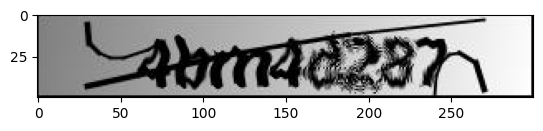

Number of letters extracted: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4bmn4d287


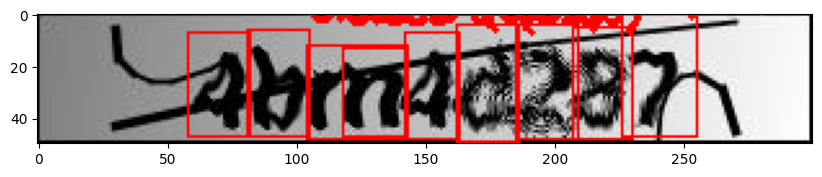

In [34]:

rendnum = random.choice(range(30 , 500))
# image_path_test = f"captchas/captcha_{rendnum}.png"
# print(f"image number : {rendnum}")
image_path_test = "kaggledataset/1.png"
image_test = cv2.imread(image_path_test)
model_test = YOLO("yolo_model2/best.pt")
results_test = model_test(image_path_test)
detections_test = results_test[0].boxes
detections_test = sorted(detections_test, key=lambda box: box.xyxy[0][0])

def check_letter_tarakom(pic):
    _, pic = cv2.threshold(pic, 127, 255, cv2.THRESH_BINARY)
    s = 90 - (np.sum(pic , axis=0 , keepdims=True) / 255)
    total = len(s[0])
    howmanyblack = 0
    for i in s[0]:
        if np.sum(i) >= 175:
            howmanyblack += 1
    if total - howmanyblack <= 22:
        return True
    else:
        return False

letters_test = []

last_one = []

howmany = 0 
for box in detections_test:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    if last_one != []:
        if int(x1) - last_one[0] > 10:
            letter_crop = image_test[y1:y2, x1:x2] 
            resized_letter = cv2.resize(letter_crop, (32, 52)) 
            resized_letter = cv2.cvtColor(resized_letter, cv2.COLOR_BGR2GRAY) 
            if howmany == 8:
                if check_letter_tarakom(letter_crop) == True:
                        _, binarized = cv2.threshold(resized_letter, 128, 255, cv2.THRESH_BINARY)
                        letters_test.append(resized_letter)
            elif howmany <= 7:
                    _, binarized = cv2.threshold(resized_letter, 128, 255, cv2.THRESH_BINARY)
                    letters_test.append(resized_letter)
            last_one = [int(x1), int(y1), int(x2), int(y2)]
            howmany += 1
    else:
        letter_crop = image_test[y1:y2, x1:x2] 
        resized_letter = cv2.resize(letter_crop, (32, 52)) 
        resized_letter = cv2.cvtColor(resized_letter, cv2.COLOR_BGR2GRAY)
        if check_letter_tarakom(letter_crop) == True:
                _, binarized = cv2.threshold(resized_letter, 128, 255, cv2.THRESH_BINARY)
                letters_test.append(resized_letter)
        last_one = [int(x1), int(y1), int(x2), int(y2)]
        howmany += 1

show_image(image_test)
print(f"Number of letters extracted: {len(letters_test)}")

allpredicted = []

for i in range(0,len(letters_test)):
    sample_image = np.array(letters_test[i])  
    sample_image = sample_image.reshape(1, 52, 32, 1) 
    predicted_label = model.predict(sample_image)
    predicted_class = label_encoder.inverse_transform([predicted_label.argmax()])
    allpredicted.append(predicted_class[0])
captcha_result = "".join(allpredicted)
print(captcha_result)
#-------------------
last_one = []

def add_to_dataset(add:False , allpredicted , lab:str):
    global image_test
    tosave = image_test.copy()
    if add == True:
        if f"kaggledataset/{lab}.png" not in os.listdir("kaggledataset"):
            cv2.imwrite(f"kaggledataset/{lab}.png" , tosave)
            print("saved")
        else:
            print("existed")
for_show = image_test.copy()

howmany = 0 
for box in detections_test:
    try:
        x1, y1, x2, y2 = box.xyxy[0].tolist() 
        if last_one != []:
            if  int(x1) - last_one[0] >= 11:
                confidence = box.conf[0] 
                cls = int(box.cls[0]) 
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                ff = for_show[y1:y2, x1:x2]
                if howmany == 8:
                    if check_letter_tarakom(ff) == True:
                        cv2.rectangle(for_show, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)
                elif howmany <= 7:
                    cv2.rectangle(for_show, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)
                
                labelr = f"Class {cls} ({confidence:.2f})"
                cv2.putText(for_show, labelr, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                last_one = [int(x1), int(y1), int(x2), int(y2)]
                howmany +=1
        else:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            ff = for_show[y1:y2, x1:x2]
            if check_letter_tarakom(ff) == True:
                cv2.rectangle(for_show, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)
            last_one = [int(x1), int(y1), int(x2), int(y2)]
            howmany +=1
    except Exception as e:
        print(e)
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        ff = for_show[y1:y2, x1:x2]
        cv2.rectangle(for_show, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)
        last_one = [int(x1), int(y1), int(x2), int(y2)]
        howmany += 1

plt.figure(figsize=(10, 10))  
plt.imshow(for_show)
plt.show()


